In [1]:
import pandas as pd
import numpy as np
import sqlite3
from sqlalchemy import create_engine
from datetime import datetime, time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

%config InlineBackend.figure_format = 'svg'
%matplotlib inline 

In [ ]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt" #url with formatting to fill in the number of the particular week
    dfs = []
    for week_num in week_nums: #for each week
        file_url = url.format(week_num) #format the url so it grabs that week
        dfs.append(pd.read_csv(file_url)) #append to our empty list
    return pd.concat(dfs) #combine files for each week


start_date = '12/29/2018'
num_per = 24
data_collection_period = pd.date_range(start = start_date, periods = num_per, freq = 'W-SAT')
week_nums = []
for item in data_collection_period:
    week_nums.append(int((str(item).rstrip('0:').lstrip('20').replace('-', '')).strip()))

turnstiles_df = get_data(week_nums) #use our function to get a df with all of our data

In [ ]:
csv_filename = f'mta_data_{week_nums[0]}_to_{week_nums[-1]}.csv'
turnstiles_df.to_csv(csv_filename, header = False, index = False)

In [2]:
engine = create_engine("sqlite:///mta.db")
all_data = pd.read_sql('SELECT * FROM mta_data;', engine)

In [3]:
#add a column with dtype datetime64 with combined date and time
all_data['DATE_TIME'] = pd.to_datetime(all_data.DATE + " " + all_data.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [4]:
#create a new column categorizing the time of day into night, morning, afternoon, evening
all_data['TIME_OF_DAY'] = pd.cut(all_data.DATE_TIME.dt.hour,
                                bins = [0, 3, 6, 9, 12, 15, 18, 21, 24],
                                labels = ['Late Night', 'Early Morning', 'Morning', 'Mid-Morning', 'Early Afternoon', 'Late Afternoon', 'Evening', 'Night'],
                                right = False,
                                include_lowest = True)

In [5]:
#look for duplicate values (same turnstile with two entries for same timestamp)
(all_data
 .groupby(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values(["ENTRIES", "STATION"], ascending=[False, True])).head()

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES
4068394,R306,R207,00-00-00,135 ST,2019-04-08 16:00:00,2
4069382,R306,R207,00-00-01,135 ST,2019-04-08 16:00:00,2
121837,A034,R170,03-03-00,14 ST-UNION SQ,2019-03-12 17:00:00,2
128012,A035,R170,00-00-00,14 ST-UNION SQ,2019-03-27 17:00:00,2
129032,A035,R170,00-00-01,14 ST-UNION SQ,2019-03-27 17:00:00,2


In [6]:
#examining a specific turnstile to look at duplicates
mask = ((all_data["CA"] == "R306") & 
(all_data["UNIT"] == "R207") & 
(all_data["SCP"] == "00-00-01") & 
(all_data["STATION"] == "135 ST") &
(all_data["DATE_TIME"].dt.date == datetime(2019, 4, 8).date()))

all_data[mask].head()

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TIME_OF_DAY
3214454,R306,R207,00-00-01,135 ST,23,IRT,04/08/2019,00:00:00,REGULAR,1691175,224569,2019-04-08 00:00:00,late night
3214455,R306,R207,00-00-01,135 ST,23,IRT,04/08/2019,04:00:00,REGULAR,1691192,224574,2019-04-08 04:00:00,early morning
3214456,R306,R207,00-00-01,135 ST,23,IRT,04/08/2019,08:00:00,REGULAR,1691539,224618,2019-04-08 08:00:00,morning
3214457,R306,R207,00-00-01,135 ST,23,IRT,04/08/2019,08:54:41,REGULAR,1691845,224650,2019-04-08 08:54:41,morning
3214458,R306,R207,00-00-01,135 ST,23,IRT,04/08/2019,12:00:00,REGULAR,1692248,224689,2019-04-08 12:00:00,early afternoon
3214459,R306,R207,00-00-01,135 ST,23,IRT,04/08/2019,16:00:00,REGULAR,1692614,224735,2019-04-08 16:00:00,late afternoon
3214460,R306,R207,00-00-01,135 ST,23,IRT,04/08/2019,16:00:00,RECOVR AUD,336698,232807,2019-04-08 16:00:00,late afternoon
3214461,R306,R207,00-00-01,135 ST,23,IRT,04/08/2019,20:00:00,REGULAR,1693111,224788,2019-04-08 20:00:00,evening


In [7]:
all_data.DESC.value_counts()

REGULAR       4864888
RECOVR AUD      21903
Name: DESC, dtype: int64

In [5]:
all_data.sort_values(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace = True, ascending = False)
all_data.drop_duplicates(subset = ["CA", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace = True)

In [6]:
(all_data
 .groupby(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2018-12-22 03:00:00,1
3257780,R141,R031,00-03-01,34 ST-PENN STA,2019-04-02 20:00:00,1
3257778,R141,R031,00-03-01,34 ST-PENN STA,2019-04-02 12:00:00,1
3257777,R141,R031,00-03-01,34 ST-PENN STA,2019-04-02 08:00:00,1
3257776,R141,R031,00-03-01,34 ST-PENN STA,2019-04-02 04:00:00,1


In [7]:
all_data['LINENAME'].nunique()

114

In [8]:
#sort the line names uniformly so that common values are used to group appropriately
all_data['LINENAME'] = all_data['LINENAME'].apply(lambda x : ''.join(sorted(x)))

In [9]:
all_data['LINENAME'].nunique()

95

In [18]:
turnstiles_daily = all_data.groupby(['CA', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DATE'], as_index = False).first()

In [11]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["CA", "UNIT", "SCP", "STATION", 'LINENAME'])[["DATE", "ENTRIES"]]
                                                       .shift(1))

In [12]:
turnstiles_daily.dropna(subset=["PREV_DATE"], axis = 0, inplace = True)

In [13]:
turnstiles_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804813 entries, 1 to 809750
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   CA            804813 non-null  object        
 1   UNIT          804813 non-null  object        
 2   SCP           804813 non-null  object        
 3   STATION       804813 non-null  object        
 4   LINENAME      804813 non-null  object        
 5   DATE          804813 non-null  object        
 6   DIVISION      804813 non-null  object        
 7   TIME          804813 non-null  object        
 8   DESC          804813 non-null  object        
 9   ENTRIES       804813 non-null  int64         
 10  EXITS         804813 non-null  int64         
 11  DATE_TIME     804813 non-null  datetime64[ns]
 12  TIME_OF_DAY   804813 non-null  category      
 13  PREV_DATE     804813 non-null  object        
 14  PREV_ENTRIES  804813 non-null  float64       
dtypes: category(1), d

In [14]:
#identify rows that are comparing readings from different devices and set to nan
turnstiles_daily.mask(turnstiles_daily['SCP'] != turnstiles_daily['SCP'].shift(1), inplace = True)

In [15]:
turnstiles_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804813 entries, 1 to 809750
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   CA            799885 non-null  object        
 1   UNIT          799885 non-null  object        
 2   SCP           799885 non-null  object        
 3   STATION       799885 non-null  object        
 4   LINENAME      799885 non-null  object        
 5   DATE          799885 non-null  object        
 6   DIVISION      799885 non-null  object        
 7   TIME          799885 non-null  object        
 8   DESC          799885 non-null  object        
 9   ENTRIES       799885 non-null  float64       
 10  EXITS         799885 non-null  float64       
 11  DATE_TIME     799885 non-null  datetime64[ns]
 12  TIME_OF_DAY   799885 non-null  category      
 13  PREV_DATE     799885 non-null  object        
 14  PREV_ENTRIES  799885 non-null  float64       
dtypes: category(1), d

In [16]:
turnstiles_daily.dropna(how = 'all', inplace = True)

In [17]:
(turnstiles_daily["ENTRIES"] - turnstiles_daily["PREV_ENTRIES"]).describe()

count    7.998850e+05
mean    -1.798119e+03
std      1.272646e+07
min     -2.071639e+09
25%      2.190000e+02
50%      7.400000e+02
75%      1.482000e+03
max      2.088504e+09
dtype: float64

In [18]:
turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].sample(5)
#first day is comparing the wrong dates - comparing the first day values to the values from the last day in the data
#set. Maybe after running diff to get daily entries, drop the rows where the date is more than 1 day beyond previous
#entry.
#some counters may also be rolling over. going from extremely large positive values to very small positive values
#count extreme values and compare to total entries, maybe drop extreme (< 0 and > 50000)?

,CA,UNIT,SCP,STATION,LINENAME,DATE,DIVISION,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TIME_OF_DAY,PREV_DATE,PREV_ENTRIES
205585,N063A,R011,00-00-05,42 ST-PORT AUTH,ACENQRS1237W,02/07/2019,IND,23:00:00,REGULAR,1.556413e+09,9.241252e+08,2019-02-07 23:00:00,evening,02/06/2019,1.556417e+09
305647,N305,R017,01-03-04,LEXINGTON AV/53,EM6,04/08/2019,IND,20:00:00,REGULAR,3.321028e+08,1.595661e+09,2019-04-08 20:00:00,evening,04/07/2019,3.321051e+08
761622,R551,R072,01-03-05,34 ST-HUDSON YD,7,12/22/2018,IRT,23:00:00,REGULAR,1.356100e+04,2.513800e+04,2018-12-22 23:00:00,evening,06/07/2019,5.576900e+04
197713,N057,R188,00-03-02,50 ST,CE,12/22/2018,IND,23:00:00,REGULAR,1.094855e+07,4.090286e+06,2018-12-22 23:00:00,evening,06/07/2019,1.124185e+07
603488,R210,R044,00-06-00,BROOKLYN BRIDGE,456JZ,04/14/2019,IRT,16:00:00,RECOVR AUD,4.587810e+05,1.700000e+01,2019-04-14 16:00:00,afternoon,04/13/2019,1.205515e+08


In [19]:
mask = ((all_data["CA"] == "N063A") & 
(all_data["UNIT"] == "R011") & 
(all_data["SCP"] == "00-00-04") & 
(all_data["STATION"] == "42 ST-PORT AUTH") &
(all_data["DATE_TIME"].dt.date == datetime(2019, 5, 6).date()))

In [20]:
#entries are going down, exits are increasing
all_data[mask].sort_values('DATE_TIME')[['DATE', 'TIME', 'ENTRIES', 'EXITS']]

,DATE,TIME,ENTRIES,EXITS
3913724,05/06/2019,00:00:00,45169553,806301890
3913725,05/06/2019,04:00:00,45169538,806301894
3913726,05/06/2019,08:00:00,45168581,806301921
3913727,05/06/2019,12:00:00,45167075,806302021
3913728,05/06/2019,16:00:00,45166650,806302187
3913729,05/06/2019,20:00:00,45165937,806302699


In [21]:
turnstiles_daily['DAILY_ENTRIES'] = turnstiles_daily['ENTRIES'].diff()

In [22]:
turnstiles_daily['DAILY_EXITS'] = turnstiles_daily['EXITS'].diff()

In [23]:
mask = turnstiles_daily['DAILY_ENTRIES'] >= 0
turnstiles_daily[mask].describe()
#turnstiles_daily.mask(turnstiles_daily['DAILY_ENTRIES'] < 0).sort_values('DAILY_ENTRIES', ascending = False)

,ENTRIES,EXITS,PREV_ENTRIES,DAILY_ENTRIES,DAILY_EXITS
count,7.854280e+05,7.854280e+05,7.854280e+05,7.854280e+05,7.854280e+05
mean,3.039682e+07,2.446091e+07,3.032974e+07,2.800316e+05,2.132620e+05
std,1.685522e+08,1.583540e+08,1.683185e+08,1.803072e+07,1.627408e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.960883e+09
25%,3.744598e+05,1.582420e+05,3.717835e+05,2.430000e+02,1.410000e+02
50%,2.225367e+06,1.280946e+06,2.220132e+06,7.600000e+02,4.840000e+02
75%,6.617304e+06,4.528176e+06,6.610192e+06,1.505000e+03,1.096000e+03
max,2.129558e+09,2.124341e+09,2.129547e+09,2.121491e+09,2.107588e+09


In [24]:
#need to isolate where prev date isn't one day before current date and remove those rows
turnstiles_daily['DATE_TO_COMPARE'] = pd.to_datetime(turnstiles_daily['PREV_DATE'], format = "%m/%d/%Y") + pd.Timedelta(1, unit = "d")

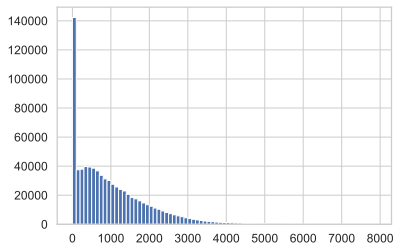

In [25]:
plt.hist(turnstiles_daily['DAILY_ENTRIES'], bins = np.arange(0, 8000, 100));

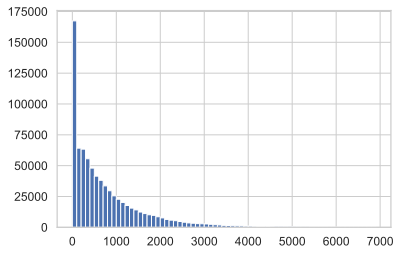

In [26]:
plt.hist(turnstiles_daily['DAILY_EXITS'], bins = np.arange(0, 7000, 100));

,CA,UNIT,SCP,STATION,LINENAME,DATE,DIVISION,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TIME_OF_DAY,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,DAILY_EXITS,DATE_TO_COMPARE
count,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885,799885,799884,799884,799885


In [28]:
# mask = (turnstiles_daily['DATE'] != turnstiles_daily['DATE_TO_COMPARE'])
# turnstiles_daily[mask].info()
turnstiles_daily.mask(turnstiles_daily['DATE'] != turnstiles_daily['DATE_TO_COMPARE'], inplace = True)

In [29]:
turnstiles_daily.dropna(subset = ['DAILY_ENTRIES'], inplace = True)

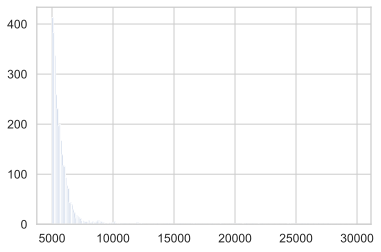

In [30]:
plt.hist(turnstiles_daily['DAILY_ENTRIES'], bins = np.arange(5000, 30000, 100));

In [31]:
turnstiles_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794158 entries, 3 to 809750
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   CA               794158 non-null  object        
 1   UNIT             794158 non-null  object        
 2   SCP              794158 non-null  object        
 3   STATION          794158 non-null  object        
 4   LINENAME         794158 non-null  object        
 5   DATE             794158 non-null  object        
 6   DIVISION         794158 non-null  object        
 7   TIME             794158 non-null  object        
 8   DESC             794158 non-null  object        
 9   ENTRIES          794158 non-null  float64       
 10  EXITS            794158 non-null  float64       
 11  DATE_TIME        794158 non-null  datetime64[ns]
 12  TIME_OF_DAY      794158 non-null  category      
 13  PREV_DATE        794158 non-null  object        
 14  PREV_ENTRIES     794

In [32]:
turnstiles_daily.mask(turnstiles_daily['DAILY_ENTRIES'] > 30000, inplace = True)
turnstiles_daily.mask(turnstiles_daily['DAILY_ENTRIES'] < 0, inplace = True)

In [33]:
turnstiles_daily.dropna(subset = ['DAILY_ENTRIES'], inplace = True)

In [34]:
turnstiles_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781493 entries, 3 to 809750
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   CA               781493 non-null  object        
 1   UNIT             781493 non-null  object        
 2   SCP              781493 non-null  object        
 3   STATION          781493 non-null  object        
 4   LINENAME         781493 non-null  object        
 5   DATE             781493 non-null  object        
 6   DIVISION         781493 non-null  object        
 7   TIME             781493 non-null  object        
 8   DESC             781493 non-null  object        
 9   ENTRIES          781493 non-null  float64       
 10  EXITS            781493 non-null  float64       
 11  DATE_TIME        781493 non-null  datetime64[ns]
 12  TIME_OF_DAY      781493 non-null  category      
 13  PREV_DATE        781493 non-null  object        
 14  PREV_ENTRIES     781

In [35]:
turnstiles_daily[turnstiles_daily['STATION'] == '23 ST'].sort_values('DAILY_ENTRIES', ascending = False).head(10)

,CA,UNIT,SCP,STATION,LINENAME,DATE,DIVISION,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TIME_OF_DAY,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,DAILY_EXITS,DATE_TO_COMPARE
613698,R227,R131,00-00-02,23 ST,6,05/14/2019,IRT,21:00:00,REGULAR,114693.0,66674.0,2019-05-14 21:00:00,evening,05/13/2019,88636.0,26057.0,28854.0,2019-05-14
217413,N076,R111,00-06-00,23 ST,CE,05/08/2019,IND,20:00:00,REGULAR,3626589.0,1310452.0,2019-05-08 20:00:00,evening,05/07/2019,3621281.0,5308.0,1296.0,2019-05-08
217414,N076,R111,00-06-00,23 ST,CE,05/09/2019,IND,20:00:00,REGULAR,3631786.0,1311821.0,2019-05-09 20:00:00,evening,05/08/2019,3626589.0,5197.0,1369.0,2019-05-09
217412,N076,R111,00-06-00,23 ST,CE,05/07/2019,IND,20:00:00,REGULAR,3621281.0,1309156.0,2019-05-07 20:00:00,evening,05/06/2019,3616134.0,5147.0,1393.0,2019-05-07
532761,R131,R190,00-00-00,23 ST,1,02/14/2019,IRT,20:00:00,REGULAR,1283059.0,411731.0,2019-02-14 20:00:00,evening,02/13/2019,1278478.0,4581.0,1567.0,2019-02-14
217440,N076,R111,00-06-00,23 ST,CE,06/04/2019,IND,20:00:00,REGULAR,3703941.0,1333729.0,2019-06-04 20:00:00,evening,06/03/2019,3699364.0,4577.0,1038.0,2019-06-04
532858,R131,R190,00-00-00,23 ST,1,05/22/2019,IRT,21:00:00,REGULAR,1652082.0,545266.0,2019-05-22 21:00:00,evening,05/21/2019,1647520.0,4562.0,1609.0,2019-05-22
614185,R227,R131,00-00-05,23 ST,6,05/03/2019,IRT,21:00:00,REGULAR,106373.0,34416.0,2019-05-03 21:00:00,evening,05/02/2019,101816.0,4557.0,1303.0,2019-05-03
532823,R131,R190,00-00-00,23 ST,1,04/17/2019,IRT,21:00:00,REGULAR,1522932.0,497645.0,2019-04-17 21:00:00,evening,04/16/2019,1518390.0,4542.0,1558.0,2019-04-17
532810,R131,R190,00-00-00,23 ST,1,04/04/2019,IRT,21:00:00,REGULAR,1471276.0,479255.0,2019-04-04 21:00:00,evening,04/03/2019,1466735.0,4541.0,1583.0,2019-04-04


In [36]:
turnstiles_daily[turnstiles_daily['STATION'] == '34 ST-HERALD SQ'].sort_values('DAILY_ENTRIES', ascending = False).head(10)

,CA,UNIT,SCP,STATION,LINENAME,DATE,DIVISION,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TIME_OF_DAY,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,DAILY_EXITS,DATE_TO_COMPARE
385886,N506,R022,00-05-05,34 ST-HERALD SQ,BDFMNQRW,12/27/2018,IND,23:00:00,REGULAR,190165.0,112643.0,2018-12-27 23:00:00,evening,12/26/2018,182945.0,7220.0,2554.0,2018-12-27
383521,N505,R022,02-06-01,34 ST-HERALD SQ,BDFMNQRW,05/31/2019,IND,20:00:00,REGULAR,633215.0,232838.0,2019-05-31 20:00:00,evening,05/30/2019,627006.0,6209.0,1100.0,2019-05-31
11843,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,04/23/2019,BMT,20:00:00,REGULAR,26827295.0,11111916.0,2019-04-23 20:00:00,evening,04/22/2019,26821245.0,6050.0,2811.0,2019-04-23
385873,N506,R022,00-05-05,34 ST-HERALD SQ,BDFMNQRW,05/31/2019,IND,20:00:00,REGULAR,929976.0,693406.0,2019-05-31 20:00:00,evening,05/30/2019,923993.0,5983.0,3676.0,2019-05-31
385880,N506,R022,00-05-05,34 ST-HERALD SQ,BDFMNQRW,06/07/2019,IND,20:00:00,REGULAR,967145.0,717846.0,2019-06-07 20:00:00,evening,06/06/2019,961175.0,5970.0,3676.0,2019-06-07
11888,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,06/07/2019,BMT,20:00:00,REGULAR,27041335.0,11227066.0,2019-06-07 20:00:00,evening,06/06/2019,27035380.0,5955.0,2753.0,2019-06-07
385864,N506,R022,00-05-05,34 ST-HERALD SQ,BDFMNQRW,05/22/2019,IND,20:00:00,REGULAR,885285.0,661340.0,2019-05-22 20:00:00,evening,05/21/2019,879343.0,5942.0,3782.0,2019-05-22
12201,A022,R022,01-00-02,34 ST-HERALD SQ,BDFMNQRW,05/15/2019,BMT,20:00:00,REGULAR,14792004.0,5839933.0,2019-05-15 20:00:00,evening,05/14/2019,14786119.0,5885.0,2417.0,2019-05-15
385879,N506,R022,00-05-05,34 ST-HERALD SQ,BDFMNQRW,06/06/2019,IND,20:00:00,REGULAR,961175.0,714170.0,2019-06-06 20:00:00,evening,06/05/2019,955326.0,5849.0,3739.0,2019-06-06
11887,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,06/06/2019,BMT,20:00:00,REGULAR,27035380.0,11224313.0,2019-06-06 20:00:00,evening,06/05/2019,27029575.0,5805.0,2887.0,2019-06-06


In [61]:
station_daily = turnstiles_daily.groupby(['STATION','LINENAME', 'DATE'])['DAILY_ENTRIES'].sum().reset_index()
station_daily.head()

,STATION,LINENAME,DATE,DAILY_ENTRIES
0,1 AV,L,01/04/2019,20389.0
1,1 AV,L,01/05/2019,13930.0
2,1 AV,L,01/06/2019,12021.0
3,1 AV,L,01/07/2019,19538.0
4,1 AV,L,01/08/2019,20414.0


In [ ]:
# station_daily[station_daily['STATION'] == '23 ST'].head(10)

In [92]:
station_daily['STATION_AND_LINE'] = station_daily['STATION'] + ' ' + station_daily['LINENAME']

In [63]:
station_totals = station_daily.groupby(['STATION', 'LINENAME'])['DAILY_ENTRIES'].sum().reset_index().sort_values('DAILY_ENTRIES', ascending = False)

In [ ]:
# station_totals['STATION'].unique()

In [ ]:
# station_totals[station_totals['STATION'] == '23 ST']

In [ ]:
# station_totals[station_totals['STATION'] == 'GRD CNTRL-42 ST']

In [64]:
station_totals.sort_values('DAILY_ENTRIES', inplace = True, ascending = False)

In [67]:
station_totals['STATION_AND_LINE'] = station_totals['STATION'] + " " + station_totals['LINENAME']

In [75]:
#station_totals.groupby('STATION')[['STATION', 'STATION_AND_LINE', 'DAILY_ENTRIES']].head(5)

,STATION,STATION_AND_LINE,DAILY_ENTRIES
313,GRD CNTRL-42 ST,GRD CNTRL-42 ST 4567S,20150186.0
90,34 ST-HERALD SQ,34 ST-HERALD SQ BDFMNQRW,16193386.0
94,34 ST-PENN STA,34 ST-PENN STA ACE,11413951.0
103,42 ST-PORT AUTH,42 ST-PORT AUTH ACENQRS1237W,11063750.0
28,14 ST-UNION SQ,14 ST-UNION SQ LNQR456W,9924933.0
...,...,...,...
205,BEACH 98 ST,BEACH 98 ST AS,62323.0
222,BROAD CHANNEL,BROAD CHANNEL AS,42308.0
198,BEACH 105 ST,BEACH 105 ST AS,30947.0
10,111 ST,111 ST J,29608.0


In [ ]:
# plt.bar(station_totals.loc[[61, 233, 59, 46, 14], 'STATION'], station_totals.loc[[61, 233, 59, 46, 14], 'DAILY_ENTRIES'] / 1000000)
# plt.xticks(rotation = 45)
# plt.xlabel('Station Name')
# plt.ylabel('Total Turnstile Entries (millions)')
# plt.ticklabel_format(axis = 'y', style = 'plain')
# plt.title('Top 5 NYC Subway Stations 12/23/2018 - 6/7/2019');

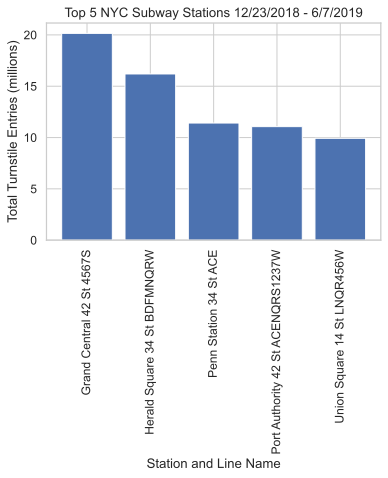

In [117]:
#same as above, without static references to the indices we want
plt.bar(station_totals['STATION_AND_LINE'][:5], station_totals['DAILY_ENTRIES'][:5] / 1000000)
plt.xticks(rotation = 90, ticks = np.arange(5), labels = ['Grand Central 42 St 4567S', 'Herald Square 34 St BDFMNQRW', 'Penn Station 34 St ACE', 'Port Authority 42 St ACENQRS1237W', 'Union Square 14 St LNQR456W'])
plt.xlabel('Station and Line Name')
plt.ylabel('Total Turnstile Entries (millions)')
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.title('Top 5 NYC Subway Stations 12/23/2018 - 6/7/2019')
plt.savefig('top_5_stations.png', facecolor = 'w', dpi = 100, bbox_inches = 'tight');

In [86]:
station_daily['DATE'] = pd.to_datetime(station_daily['DATE'])

In [87]:
station_daily['DAY_OF_WEEK'] = station_daily['DATE'].dt.dayofweek

In [88]:
station_daily['DAY_OF_WEEK'] = station_daily['DAY_OF_WEEK'].map({0 : 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

In [45]:
station_daily.sort_values('DAILY_ENTRIES', ascending = False).head(20)

,STATION,DATE,DAILY_ENTRIES,DAY_OF_WEEK
10059,34 ST-PENN STA,2019-02-28,182996.0,Thursday
10143,34 ST-PENN STA,2019-05-23,182559.0,Thursday
10037,34 ST-PENN STA,2019-02-06,182226.0,Wednesday
10066,34 ST-PENN STA,2019-03-07,180752.0,Thursday
10072,34 ST-PENN STA,2019-03-13,180706.0,Wednesday
10134,34 ST-PENN STA,2019-05-14,179664.0,Tuesday
10073,34 ST-PENN STA,2019-03-14,179560.0,Thursday
10065,34 ST-PENN STA,2019-03-06,179553.0,Wednesday
10094,34 ST-PENN STA,2019-04-04,179505.0,Thursday
10101,34 ST-PENN STA,2019-04-11,179430.0,Thursday


In [89]:
station_daily['NUMERIC_DAY_OF_WEEK'] = pd.to_datetime(station_daily['DATE']).dt.dayofweek

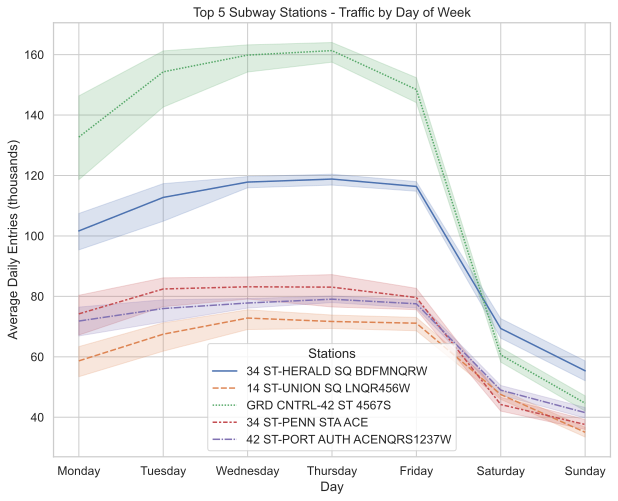

In [118]:
station_daily.sort_values('NUMERIC_DAY_OF_WEEK', ascending = True, inplace = True)
mask = station_daily['STATION_AND_LINE'].isin(['GRD CNTRL-42 ST 4567S', '34 ST-HERALD SQ BDFMNQRW', '34 ST-PENN STA ACE', '42 ST-PORT AUTH ACENQRS1237W', '14 ST-UNION SQ LNQR456W'])

fig, ax = plt.subplots(figsize = (10, 8))
g = sns.lineplot(data = station_daily[mask], x = station_daily[mask]['DAY_OF_WEEK'], y = station_daily[mask]['DAILY_ENTRIES'] / 1000, style = station_daily[mask]['STATION_AND_LINE'], hue = station_daily[mask]['STATION_AND_LINE'])

ax.legend(title = 'Stations', loc = 'lower center')
g.set_title('Top 5 Subway Stations - Traffic by Day of Week')
g.set_xlabel("Day")
g.set_ylabel("Average Daily Entries (thousands)")
fig.savefig("daily_traffic.png", facecolor = 'w');

In [96]:
station_daily['NUMERIC_MONTH'] = pd.to_datetime(station_daily['DATE']).dt.month
months = {1 : 'January',
         2 : 'February',
         3 : 'March',
         4 : 'April',
         5 : 'May',
         6 : 'June',
         7 : 'July',
         8 : 'August',
         9 : 'September',
         10 : 'October',
         11 : 'November',
         12 : 'December'}
station_daily['MONTH'] = station_daily['NUMERIC_MONTH'].map(months)
station_daily

,STATION,LINENAME,DATE,DAILY_ENTRIES,DAY_OF_WEEK,NUMERIC_DAY_OF_WEEK,STATION_AND_LINE,NUMERIC_MONTH,MONTH
77994,ZEREGA AV,6,2018-12-31,1747.0,Monday,0,ZEREGA AV 6,12,December
30119,AVENUE P,F,2019-04-29,2558.0,Monday,0,AVENUE P F,4,April
59764,METROPOLITAN AV,M,2019-05-20,3123.0,Monday,0,METROPOLITAN AV M,5,May
30070,AVENUE P,F,2019-03-11,2387.0,Monday,0,AVENUE P F,3,March
30112,AVENUE P,F,2019-04-22,2030.0,Monday,0,AVENUE P F,4,April
...,...,...,...,...,...,...,...,...,...
54384,JAMAICA 179 ST,F,2018-12-30,7002.0,Sunday,6,JAMAICA 179 ST F,12,December
38990,CATHEDRAL PKWY,1,2019-01-13,6606.0,Sunday,6,CATHEDRAL PKWY 1,1,January
54388,JAMAICA CENTER,EJZ,2019-01-06,9349.0,Sunday,6,JAMAICA CENTER EJZ,1,January
38802,CARROLL ST,FG,2019-06-02,5712.0,Sunday,6,CARROLL ST FG,6,June


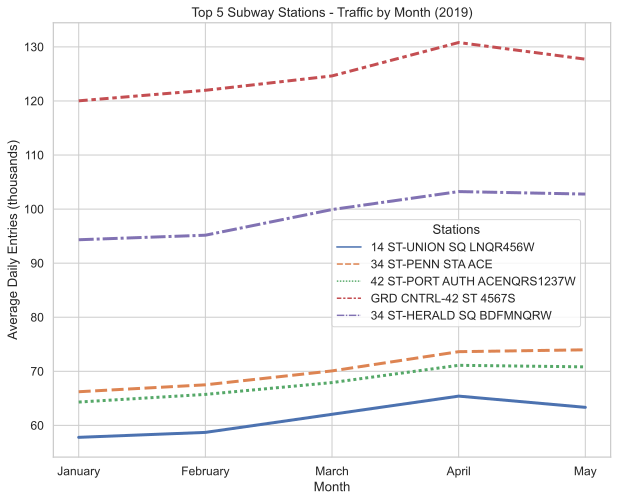

In [119]:
station_daily.sort_values('NUMERIC_MONTH', ascending = True, inplace = True)
mask = (station_daily['STATION_AND_LINE'].isin(['GRD CNTRL-42 ST 4567S', '34 ST-HERALD SQ BDFMNQRW', '34 ST-PENN STA ACE', '42 ST-PORT AUTH ACENQRS1237W', '14 ST-UNION SQ LNQR456W'])) \
        & (station_daily['NUMERIC_MONTH'].isin([1, 2, 3, 4, 5]))
fig, ax = plt.subplots(figsize = (10, 8))

g = sns.lineplot(data = station_daily[mask], x = station_daily[mask]['MONTH'], y = station_daily[mask]['DAILY_ENTRIES'] \
             / 1000, style = station_daily[mask]['STATION_AND_LINE'], \
             hue = station_daily[mask]['STATION_AND_LINE'], ci = None, linewidth = 3)

ax.legend(loc = (.5, .3), title = 'Stations')
g.set_title('Top 5 Subway Stations - Traffic by Month (2019)')
g.set_xlabel("Month")
g.set_ylabel("Average Daily Entries (thousands)")
fig.savefig("monthly_traffic.png", facecolor = 'w');

In [ ]:
#station_daily_day_of_week = station_daily.groupby(['STATION','DAY_OF_WEEK']).DAILY_ENTRIES.sum().reset_index()

In [ ]:
#station_daily_day_of_week[station_daily_day_of_week['DAY_OF_WEEK'] == 'Tuesday'].sort_values('DAILY_ENTRIES', ascending = False)

In [ ]:
#station_daily_day_of_week[station_daily_day_of_week['DAY_OF_WEEK'] == 'Monday'].sort_values('DAILY_ENTRIES', ascending = False).index[0]

In [28]:
all_data.groupby(['STATION', 'LINENAME', 'DATE', 'TIME_OF_DAY'], as_index = False).head()

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TIME_OF_DAY
4886790,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/06/2019,09:00:00,REGULAR,5554,379,2019-06-06 09:00:00,morning
4886789,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/06/2019,05:00:00,REGULAR,5554,379,2019-06-06 05:00:00,night
4886788,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/06/2019,01:00:00,REGULAR,5554,379,2019-06-06 01:00:00,night
4886787,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2019,21:00:00,REGULAR,5554,379,2019-06-05 21:00:00,evening
4886786,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2019,17:00:00,RECOVR AUD,5554,379,2019-06-05 17:00:00,afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,A007,R079,01-05-01,5 AV/59 ST,NQRW,BMT,12/23/2018,21:00:00,REGULAR,1,1275,2018-12-23 21:00:00,evening
898,A007,R079,01-05-01,5 AV/59 ST,NQRW,BMT,12/23/2018,09:00:00,REGULAR,1,1275,2018-12-23 09:00:00,morning
895,A007,R079,01-05-01,5 AV/59 ST,NQRW,BMT,12/22/2018,21:00:00,REGULAR,1,1275,2018-12-22 21:00:00,evening
892,A007,R079,01-05-01,5 AV/59 ST,NQRW,BMT,12/22/2018,09:00:00,REGULAR,1,1275,2018-12-22 09:00:00,morning


In [10]:
all_data.sort_values(['CA', 'UNIT', 'SCP', 'STATION', 'LINENAME','DATE_TIME'], ascending = False, inplace = True)
turnstiles_hourly = all_data

In [11]:
#have to reduce date range to perform diff operations, smaller data set
mask = (turnstiles_hourly['DATE_TIME'].dt.date >= datetime(2019, 4, 7).date()) & (turnstiles_hourly['DATE_TIME'].dt.date <= datetime(2019, 4, 13).date())
turnstiles_hourly = turnstiles_hourly[mask]

In [12]:
turnstiles_hourly['TOD_ENTRIES'] = turnstiles_hourly['ENTRIES'].diff()

<ipython-input-12-f212a2d47fd7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_hourly['TOD_ENTRIES'] = turnstiles_hourly['ENTRIES'].diff()


In [13]:
turnstiles_hourly['TOD_EXITS'] = turnstiles_hourly['EXITS'].diff()

<ipython-input-13-808ea72cf9ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_hourly['TOD_EXITS'] = turnstiles_hourly['EXITS'].diff()


In [14]:
turnstiles_hourly.dropna(how = 'any', axis = 0, inplace = False)

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TIME_OF_DAY,TOD_ENTRIES,TOD_EXITS
3451101,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/13/2019,17:00:00,REGULAR,5554,374,2019-04-13 17:00:00,Late Afternoon,0.0,0.0
3451100,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/13/2019,13:00:00,REGULAR,5554,374,2019-04-13 13:00:00,Early Afternoon,0.0,0.0
3451099,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/13/2019,09:00:00,REGULAR,5554,374,2019-04-13 09:00:00,Mid-Morning,0.0,0.0
3451098,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/13/2019,05:00:00,REGULAR,5554,374,2019-04-13 05:00:00,Early Morning,0.0,0.0
3451097,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/13/2019,01:00:00,REGULAR,5554,374,2019-04-13 01:00:00,Late Night,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3043891,A002,R051,02-00-00,59 ST,456NQRW,BMT,04/07/2019,16:00:00,REGULAR,7009806,2376916,2019-04-07 16:00:00,Late Afternoon,-237.0,-58.0
3043890,A002,R051,02-00-00,59 ST,456NQRW,BMT,04/07/2019,12:00:00,REGULAR,7009580,2376880,2019-04-07 12:00:00,Early Afternoon,-226.0,-36.0
3043889,A002,R051,02-00-00,59 ST,456NQRW,BMT,04/07/2019,08:00:00,REGULAR,7009487,2376819,2019-04-07 08:00:00,Morning,-93.0,-61.0
3043888,A002,R051,02-00-00,59 ST,456NQRW,BMT,04/07/2019,04:00:00,REGULAR,7009480,2376798,2019-04-07 04:00:00,Early Morning,-7.0,-21.0


In [17]:
mask = turnstiles_hourly['TOD_EXITS'] < 0
turnstiles_hourly[mask]['TOD_EXITS'].describe()

count    1.717650e+05
mean    -8.386900e+05
std      3.159859e+07
min     -2.118992e+09
25%     -2.110000e+02
50%     -7.900000e+01
75%     -2.300000e+01
max     -1.000000e+00
Name: TOD_EXITS, dtype: float64

In [18]:
turnstiles_hourly['TOD_ENTRIES'] = turnstiles_hourly['TOD_ENTRIES'].apply(lambda x : abs(x))
turnstiles_hourly['TOD_EXITS'] = turnstiles_hourly['TOD_EXITS'].apply(lambda x : abs(x))

<ipython-input-18-a779017e5ce3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_hourly['TOD_ENTRIES'] = turnstiles_hourly['TOD_ENTRIES'].apply(lambda x : abs(x))
<ipython-input-18-a779017e5ce3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_hourly['TOD_EXITS'] = turnstiles_hourly['TOD_EXITS'].apply(lambda x : abs(x))


KeyboardInterrupt: 

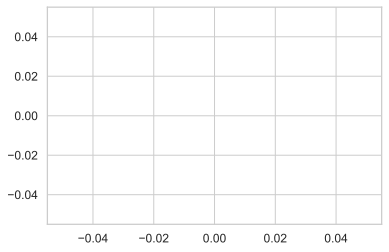

In [16]:
mask = turnstiles_hourly['STATION'] == 'GRD CNTRL-42 ST'
sns.histplot(data = turnstiles_hourly[mask]['TOD_ENTRIES']);

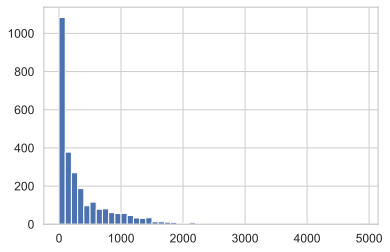

In [19]:
mask = (turnstiles_hourly['STATION'] == 'GRD CNTRL-42 ST') # & (turnstiles_hourly['DATE_TIME'].dt.date == datetime(2019,4,9).date())
plt.hist(turnstiles_hourly[mask]['TOD_ENTRIES'], bins = np.arange(0, 5000, 100));

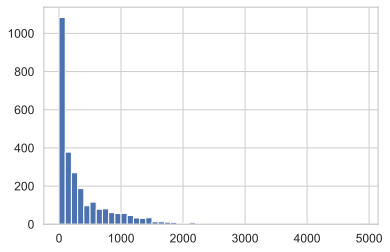

In [20]:
mask = (turnstiles_hourly['STATION'] == 'GRD CNTRL-42 ST') # & (turnstiles_hourly['DATE_TIME'].dt.date == datetime(2019,4,9).date())
plt.hist(turnstiles_hourly[mask]['TOD_ENTRIES'], bins = np.arange(0, 5000, 100));

In [29]:
turnstiles_hourly.describe()

,ENTRIES,EXITS,TOD_ENTRIES,TOD_EXITS
count,2.048230e+05,2.048230e+05,2.048220e+05,2.048220e+05
mean,4.115845e+07,3.379870e+07,1.670643e+06,1.406673e+06
std,2.114745e+08,1.954590e+08,4.437133e+07,4.111176e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.635255e+05,1.544620e+05,1.100000e+01,9.000000e+00
50%,2.232724e+06,1.293510e+06,8.200000e+01,5.700000e+01
75%,6.782266e+06,4.637174e+06,2.690000e+02,1.860000e+02
max,2.129380e+09,2.124176e+09,2.121186e+09,2.118992e+09


In [21]:
mask = (turnstiles_hourly['TOD_ENTRIES'] < 4000) & (turnstiles_hourly['TOD_EXITS'] < 4000)
turnstiles_hourly = turnstiles_hourly[mask]
turnstiles_hourly.describe()

,ENTRIES,EXITS,TOD_ENTRIES,TOD_EXITS
count,2.000390e+05,2.000390e+05,200039.000000,200039.000000
mean,4.113802e+07,3.378729e+07,181.064297,141.409820
std,2.114228e+08,1.954256e+08,262.166610,238.914504
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,3.615180e+05,1.535070e+05,10.000000,8.000000
50%,2.231710e+06,1.290478e+06,76.000000,54.000000
75%,6.781238e+06,4.632568e+06,249.000000,171.000000
max,2.129380e+09,2.124176e+09,3978.000000,3859.000000


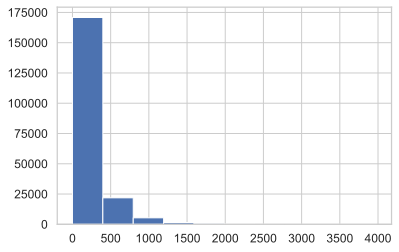

In [39]:
plt.bar(turnstiles_hourly['TOD_ENTRIES']);

In [22]:
turnstiles_hourly['STATION_AND_LINE'] = turnstiles_hourly['STATION'] + " " + turnstiles_hourly['LINENAME']

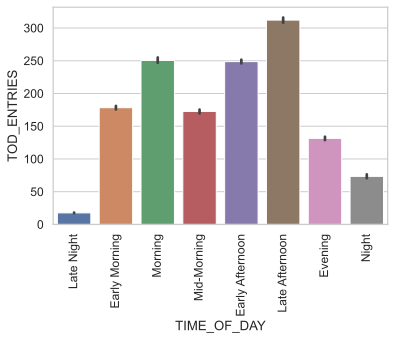

In [24]:
# mask = turnstiles_hourly['STATION_AND_LINE'].isin(['GRD CNTRL-42 ST 4567S', '34 ST-HERALD SQ BDFMNQRW', '34 ST-PENN STA ACE', '42 ST-PORT AUTH ACENQRS1237W', '14 ST-UNION SQ LNQR456W'])

sns.barplot(x = turnstiles_hourly['TIME_OF_DAY'], y = turnstiles_hourly['TOD_ENTRIES'])
# plt.bar(turnstiles_hourly[mask]['TIME_OF_DAY'], turnstiles_hourly[mask]['TOD_ENTRIES'])
plt.xticks(rotation = 90)
plt.savefig('time_of_day.png', facecolor = 'w', bbox_inches = 'tight');
# decide on date range, stations to include before plotting. also look at entries vs. exits.